## <center> Working with the NOMAD archive </center>

In this part of the tutorial we will demonstrate how to query data from the NOMAD repo and work with it within a python environment.

As an example, we will use a short simulation of an atomistic box of hexane molecules.

Import all the necessary modules. If you want to skip the molecular visualization, comment out nglview

In [35]:
# conda create -n "CECAM_tutorial" python==3.9
# conda activate CECAM_tutorial
# pip install nomad-lab
# conda install nglview
# conda install "ipywidgets <8" -c conda-forge

# NOTE: you may have to restart vscode or other editor after running these updates.

In [11]:
# Python
import numpy as np

# NOMAD tools
from nomad.atomutils import archive_to_universe
from nomad.atomutils import BeadGroup
from nomad.datamodel import EntryArchive
from nomad.units import ureg

# I/O
import json

# Visualization
import matplotlib.pyplot as plt
import nglview as nv
print(nv.__version__)

# MDAnalysis
import MDAnalysis.analysis.rdf as MDA_RDF
from MDAnalysis.analysis.distances import self_distance_array, distance_array

import requests

1.1.7


In general, you can use the [NOMAD API](https://nomad-lab.eu/prod/rae/docs/api.html) to grab particular archive entries from the repository or to search the repository for entries with certain attributes. This can be achieved in python using the `requests` module. To download an entire published entry, you just need to know the `entry_id` and then you can download the archive with a simple command:

In [71]:
# this should take ~7 m depending on the internet
entry_id = 'hxaepf6x12Xt2IX2jCt4DyfLG0P4'
nomad_url = 'https://nomad-lab.eu/prod/v1/api/v1/'
response = requests.get(nomad_url + 'entries/' + entry_id + '/archive/download')

data = response.json()

The resulting variable `data` is a dictionary. The keys of this dictionary directly correspond to the sections that we examined in the **DATA** tab on the entry page of NOMAD in Tutorial 1:

In [72]:
print(data.keys())

dict_keys(['processing_logs', 'run', 'workflow2', 'metadata', 'results', 'm_ref_archives'])


In [75]:
data['run'][0]['system'][0]

{'configuration_raw_gid': 'owQ67_x3knxNSo9RmzLoZTUNXOiE',
 'chemical_composition': 'CHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHHCHHHCHHHCHHCHHCHHCHH

Let's convert this dictionary into the internal NOMAD archive entry format, which is slightly more convenient to work with:

In [15]:
# should take ~9 s
archive = EntryArchive.m_from_dict(data)

Below we define some sections that will be used in the following cells. Take a few minutes to search through the archive, you may want to reference Tutorial 1 to help you navigate.

In [36]:
section_run = archive.run[-1]
section_system = section_run.system
section_system_topology = section_run.system[0].atoms_group
section_atoms = section_system[0].atoms

Recall that the section **run** &rarr; **system**  is a list containing configurational information from each frame in the trajectory. The following code snippet extracts the positions, velocities, and box vectors from this list: 

In [37]:
n_atoms = section_atoms.get('n_atoms')
n_frames = len(section_system) if section_system is not None else None
atom_names = section_atoms.get('labels')

# get the atom positions, velocites, and box dimensions
positions = np.empty(shape=(n_frames, n_atoms, 3))
velocities = np.empty(shape=(n_frames, n_atoms, 3))
dimensions = np.empty(shape=(n_frames, 6))
for frame_ind, frame in enumerate(section_system):
    sec_atoms_fr = frame.get('atoms')
    if sec_atoms_fr is not None:
        positions_frame = sec_atoms_fr.positions
        positions[frame_ind] = ureg.convert(positions_frame.magnitude, positions_frame.units,
                                            ureg.angstrom) if positions_frame is not None else None
        velocities_frame = sec_atoms_fr.velocities
        velocities[frame_ind] = ureg.convert(velocities_frame.magnitude, velocities_frame.units,
                                                ureg.angstrom / ureg.picosecond) if velocities_frame is not None else None
        latt_vec_tmp = sec_atoms_fr.get('lattice_vectors')
        if latt_vec_tmp is not None:
            length_conversion = ureg.convert(1.0, sec_atoms_fr.lattice_vectors.units, ureg.angstrom)
            dimensions[frame_ind] = [
                sec_atoms_fr.lattice_vectors.magnitude[0][0] * length_conversion,
                sec_atoms_fr.lattice_vectors.magnitude[1][1] * length_conversion,
                sec_atoms_fr.lattice_vectors.magnitude[2][2] * length_conversion,
                90, 90, 90]  # nb -- for cubic box!

Exercise: Fill in the missing variables assignments to make the temperature trajectory plot for this calculation. This should correspond to the one found on the overview page: ...

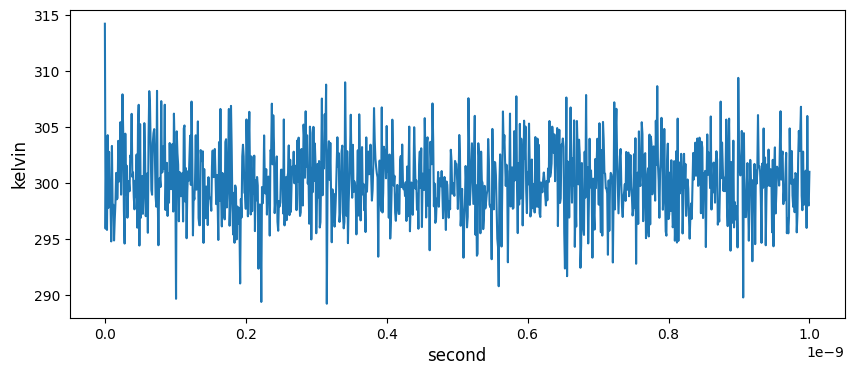

In [18]:
fig = plt.figure(figsize=(10,4))
section_calculation = archive.run[-1].calculation  ## FIND THE SECTION CALCULATION IN THE ARCHIVE ##   
temperature = []
time = []
temperature_unit = section_calculation[0].temperature.units  ## FIND THE UNIT OF TEMPERATURE USED IN THE ARCHIVE ##    
time_unit = section_calculation[0].time.units  ## FIND THE UNIT OF TIME USED IN THE ARCHIVE ##   
for calc in section_calculation:
    temperature.append(calc.temperature.magnitude)  ## FIND THE TEMPERATURE FOR THIS CALC ##
    time.append(calc.time.magnitude)  ## FIND THE TIME FOR THIS CALC ##


plt.plot(time, temperature)
plt.ylabel(temperature_unit, fontsize=12)
plt.xlabel(time_unit, fontsize=12)
plt.show()

Take some time to search through the calculation section to see what other quantities are stored there for this simulation...

Now let's plot the water-water center of mass rdf averaged over the last 80% of the trajectory, similar to what was displayed on the overview page in Tutorial 2: 

In [19]:
archive.workflow2.results

MolecularDynamicsResults(calculation_result_ref, calculations_ref, temperature, trajectory, radial_distribution_functions)

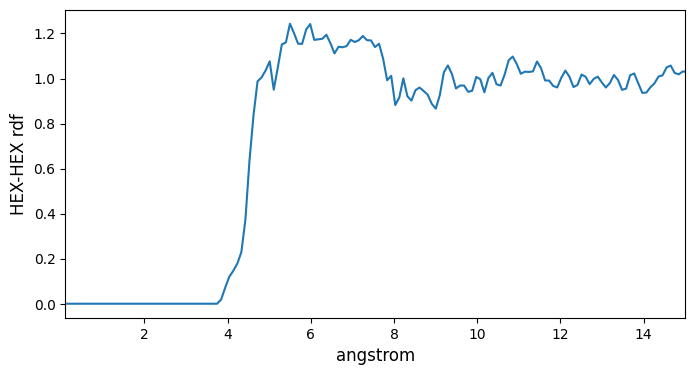

In [76]:
fig = plt.figure(figsize=(8,4))
section_MD = archive.workflow2  ## FIND THE MOLECULAR DYNAMICS WORKFLOW SECTION IN THE ARCHIVE ##
rdf_SOL_SOL = section_MD.results.radial_distribution_functions[0].radial_distribution_function_values[-1]  ## FIND THE LAST SOL-SOL RDF STORED IN THE ARCHIVE ##
rdf_start = rdf_SOL_SOL.frame_start  ## FIND THE STARTING FRAME FOR AVERAGING FOR THIS RDF ##
rdf_end = rdf_SOL_SOL.frame_end  ## FIND THE ENDING FRAME FOR AVERAGING FOR THIS RDF ##

bins = ureg.convert(rdf_SOL_SOL.bins.magnitude, rdf_SOL_SOL.bins.units, ureg.angstrom)  

plt.plot(bins, rdf_SOL_SOL.value)
plt.xlabel(ureg.angstrom, fontsize=12)
plt.ylabel('HEX-HEX rdf', fontsize=12)
plt.xlim(0.1,15.0)
plt.show()

Take some time to search through the workflow2 section to see what other quantities are stored there for this simulation...

It is already clear that it would be useful to develop converters to store the archive for an MD simulation in a format more convenient to perform analysis. In particular, one may want to utilize existing analysis software to perform standard calculations. We have already implemented a converter to the *MDAnalysis* format:

In [21]:
# should take ~10 s
universe = archive_to_universe(archive)

Let's use this format to examine the protein simulation in more detail. First, let's check which molecule type are present:

In [22]:
print('Molecule Types')
print('--------------')
for moltype in np.unique(universe.atoms.moltypes): 
    print(moltype)

Molecule Types
--------------
HEX


Let's get acquainted with the *MDAnalysis* software by reproducing the water-water molecular rdf that we plotted above.

In [23]:
# Get an atom group for the water
AG_SOL = universe.select_atoms('moltype HEX')

# Create a "bead group" for the water.
# In MDAnalysis, it is not trivial to calculate center of mass rdfs. 
# The concept of bead groups comes from a known work-around. 
# This class is imported from the NOMAD software. 
BG_SOL = BeadGroup(AG_SOL, compound="fragments")


min_box_dimension = np.min(universe.trajectory[0].dimensions[:3])
max_rdf_dist = min_box_dimension / 2
n_bins = 200
n_smooth = 2
n_prune = 1

In [24]:
# should take ~2 min
exclusion_block = (1, 1)  # for removing self-distance
rdf = MDA_RDF.InterRDF(
    BG_SOL, BG_SOL, range=(0, max_rdf_dist),
    exclusion_block=exclusion_block, nbins=n_bins).run(
    rdf_start, rdf_end, n_prune)

In [25]:
# smooth the rdf
rdf.results.bins = rdf.results.bins[int(n_smooth / 2):-int(n_smooth / 2)]
rdf.results.rdf = np.convolve(
    rdf.results.rdf, np.ones((n_smooth,)) / n_smooth,
    mode='same')[int(n_smooth / 2):-int(n_smooth / 2)]

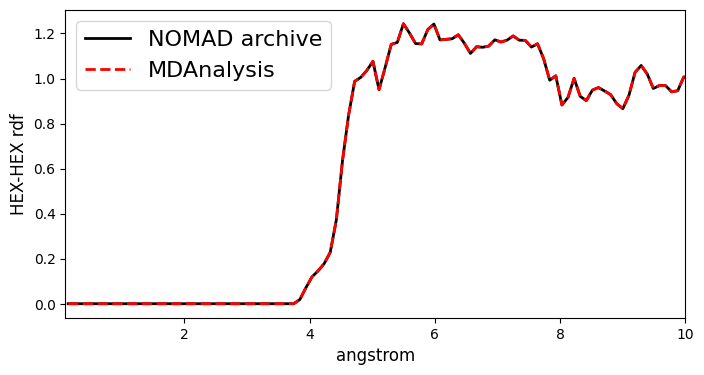

In [77]:
fig = plt.figure(figsize=(8,4))
plt.plot(bins, rdf_SOL_SOL.value, label='NOMAD archive', color='k', lw=2)
plt.plot(rdf.results.bins, rdf.results.rdf, label='MDAnalysis', linestyle='--', color='r', lw=2)

plt.legend(fontsize=16)
plt.xlabel(ureg.angstrom, fontsize=12)
plt.ylabel('HEX-HEX rdf', fontsize=12)
plt.xlim(0.1, 10.)
plt.show()

Using MDAnalysis, we can easily featurize the system for ML analysis

In [48]:
carbon_indices = [ind for ind, type in enumerate(universe.atoms.types) if type.startswith('C')]
selection = 'index ' + ' '.join([str(ind) for ind in carbon_indices])
carbons_group = universe.select_atoms(f'{selection}')

In [82]:
for i_fr, frame in enumerate(universe.trajectory):
    if i_fr == 0:
        distances = self_distance_array(carbons_group.positions, box=frame._unitcell)
    else:
        distances = np.vstack((distances, self_distance_array(carbons_group.positions, box=frame._unitcell)))

In [83]:
distances.shape

(11, 1282401)

We can visualize the system with NGLViewer

In [5]:
import MDAnalysis as MDA
path = '/home/jfrudzinski/work/GRO_DEV/MD_Overview/Hexane/Hexane_trimmed/'
sys = 'hexane.267'
tpr_fnm = sys+'.tpr'
trr_fnm = sys+'.trr'
universe = MDA.Universe(path + tpr_fnm, path + trr_fnm)

In [31]:
# select all atoms except for virtual sites associated with the water model
# should take ~15 s
AG_all = universe.select_atoms('all')
for ts in universe.trajectory:  # make the molecules whole 
    AG_all.unwrap(compound='fragments')

In [33]:
# Set up the viewer
view = nv.show_mdanalysis(AG_all)
view.center()
view.clear()  # clear the initial representation automatically set up by nglview
view.add_point('all')  # employ lightest rep
# adjust the widget size
view._set_size('700px', '600px')


view

NGLWidget(count=11)

You can adjust the visualization using nglview selection commands https://nglviewer.org/ngl/api/manual/usage/selection-language.html 

In [51]:
moltype = 'HEX'  
view.clear()
view.add_point('all')
# view.add_ball_and_stick(moltype)
view.add_spacefill('atom name .C')


In [70]:
moltype = 'HEX'  
view.clear()
view.add_point('all')
# view.add_ball_and_stick(moltype)
selection = '@' + ', '.join([str(i) for i in universe.select_atoms('molnum 0')._ix])
view.add_spacefill(selection)